In [1]:
import logging
import sys

import matplotlib.pyplot as plt

root = logging.getLogger()
root.setLevel(logging.INFO)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

In [2]:
import logging
import sys

import matplotlib.pyplot as plt

root = logging.getLogger()
root.setLevel(logging.INFO)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

In [3]:
import sys

sys.path.append('../scripts')
sys.path.append('../')
from scripts import centroids_graph_builder
from time import sleep
from multiprocessing import Pool

import numpy as np
from tqdm.notebook import trange, tqdm
from scripts import graph_osm_loader, utils

import networkx as nx

from heapq import heappop, heappush
from itertools import count
from scripts import clustering

2024-12-09 21:47:12,763 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.
2024-12-09 21:47:12,763 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


In [4]:
def get_rand_graph(N, p):
    G = nx.fast_gnp_random_graph(N, p, directed=False)
    if not nx.is_connected(G):
        tmp = []
        for n in nx.connected_components(G):
            for q in n:
                tmp.append(q)
                break
        for i in range(len(tmp) - 1):
            G.add_edge(tmp[i], tmp[i + 1])
    for e in G.edges:
        G.add_edge(e[0], e[1], length=np.random.random_sample() + 0.001)
    for u in G.nodes:
        if u in G[u]:
            G.remove_edge(u, u)
    return G

In [5]:
NUM_ITERATION = 10  # чтобы уменьшить ошибку при вычислении времени выполнения, при каждом замере время меряется для NUM_ITERATION повторений
WORKER = 5  # количество потоков

In [6]:
GRAPH_ID = 'R13470549'  # R13470549 R2555133 R3766483
# примеры id есть в graph_osm_loader.py
# g = get_rand_graph(1000, 0.1)  # загрузка графа
N = 10000
p = 3 / N
# g = get_rand_graph(N,p)
# g = get_graph()
g = graph_osm_loader.get_graph(GRAPH_ID)
print(len(g.nodes), len(g.edges))

715 1038


In [7]:
g.remove_edges_from(nx.selfloop_edges(g))

In [8]:
cms = clustering.resolve_k_means_communities(g, resolution=10, max_iteration=100, cluster_name='cluster',
                                             print_log=True)
print(len(cms))

2024-12-09 21:47:14,828 - root - INFO - communities: 88
2024-12-09 21:47:14,828 - root - INFO - communities: 88


100%|██████████| 100/100 [00:00<00:00, 161.91it/s]

88


In [9]:
cls2hubs = {}
cls2n = centroids_graph_builder.get_cls2n(g)
for i, c in enumerate(cms):
    for j in cls2n[i]:
        if (i, j) in cls2hubs:
            continue
        a = set()
        b = set()
        for u in c:
            for v in g[u]:
                if v in cms[j]:
                    a.add(u)
                    b.add(v)
        cls2hubs[i, j] = a if len(a) < len(b) else b
        cls2hubs[j, i] = a if len(a) < len(b) else b

In [10]:
cls2hub = {}  # = centroids_graph_builder.get_cls2hubs(g)
for i, j in cls2hubs:
    if i not in cls2hub:
        cls2hub[i] = set()
    cls2hub[i].update(cls2hubs[i, j])
del cls2hubs

In [11]:
hubs = set([u for v in cls2hub.values() for u in v])

In [12]:
hub2id = {h: i for i, h in enumerate(hubs)}
id2hub = {i: h for i, h in enumerate(hubs)}

In [13]:
len(set(hubs))

214

In [14]:
def dijkstra_pfa_to_set(graph: nx.Graph,
                        start: int,
                        ends: set[int]
                        ) -> \
        tuple[float, list[int]]:
    adjacency = graph._adj
    c = count()
    push = heappush
    pop = heappop
    dist = {}
    fringe = []

    dist[start] = (0.0, None)
    push(fringe, (0.0, next(c), start))
    visited = set()
    
    while fringe:
        (d, _, v) = pop(fringe)
        if v in ends:
            visited.add(v)
        if len(visited) == len(ends):
            break
        
        for u, e in adjacency[v].items():
            vu_dist = d + e['length']
            if u not in dist or dist[u][0] > vu_dist:
                dist[u] = (vu_dist, v)
                push(fringe, (vu_dist, next(c), u))
    return dist


In [15]:
def cals(data_partitions):
    part, hubs, l = data_partitions
    dst = {}

    for u in part:
        dst_u = dijkstra_pfa_to_set(g, u, hubs)
        for v in hubs:
            path = [v]
            node = v
            while dst_u[node][1] is not None:
                node = dst_u[node][1]
                path = path + [node]
            
            dst[hub2id[u], hub2id[v]] = (dst_u[v][0], path[1:-1])
                
    return dst


data = [(list(hubs)[i::WORKER], hubs, len(hubs)) for i in range(WORKER)]
with Pool(WORKER) as p:
    dst = {k: v for d in tqdm(p.imap_unordered(cals, data), total=len(data)) for k, v in d.items()}

  0%|          | 0/5 [00:00<?, ?it/s]

In [16]:
def cals(data_partitions):
    part, l = data_partitions
    res = {}
    for u in part:
        dst_u = dijkstra_pfa_to_set(g, u, cls2hub[g.nodes()[u]['cluster']])
        for v in cls2hub[g.nodes()[u]['cluster']]:
            path = [v]
            node = v
            while dst_u[node][1] is not None:
                node = dst_u[node][1]
                path = path + [node]
            res[u, v] = (dst_u[v][0], path)
    return res

data = [(list(g.nodes)[i::WORKER], hubs) for i in range(WORKER)]
with Pool(WORKER) as p:
    d_nodes = {k: v for d in tqdm(p.imap_unordered(cals, data), total=len(data)) for k, v in d.items()}

  0%|          | 0/5 [00:00<?, ?it/s]

In [17]:
from pympler.asizeof import asizeof
asizeof(d_nodes)/1024/1024, asizeof(dst)/1024/1024

(1.8871536254882812, 56.177024841308594)

In [44]:
def dijkstra_pfa_cls(g, u, v):
    nodes = g.nodes()
    c1, c2 = nodes[u]['cluster'], nodes[v]['cluster']
    if c1 == c2:
        return nx.single_source_dijkstra(g, u, v, weight='length')
    H1, H2 = None, None
    d=float('inf')
    for h1 in cls2hub[c1]:
        for h2 in cls2hub[c2]:
            tmp = d_nodes[u, h1][0] + d_nodes[v, h2][0] + dst[hub2id[h1], hub2id[h2]][0]
            if tmp < d:
                d = tmp
                H1,H2 = h1,h2
    return d, d_nodes[u,H1][1][::-1] + dst[hub2id[H1], hub2id[H2]][1][::-1] + d_nodes[v,H2][1]

In [45]:
# points = [(u,v) for u in g.nodes() for v in g.nodes() if u!=v]
points = [utils.get_node_for_initial_graph_v2(g) for _ in trange(1000, desc='generate points')]

generate points:   0%|          | 0/1000 [00:00<?, ?it/s]

In [46]:
@utils.profile(iterations=NUM_ITERATION)
def usual_path(g, p1, p2):
    return nx.single_source_dijkstra(g, p1, p2, weight='length')


@utils.profile(iterations=NUM_ITERATION)
def h_path(g, p1, p2):
    return dijkstra_pfa_cls(g, p1, p2)


def do_calc(data_partitions):
    point_partition, worker_number = data_partitions

    stat = {
        'l': [],
        'h_l': [],
        'p': [],
        'h_p': [],
        'time_l': [],
        'time_h': [],
        'delta': []
    }

    # чисто чтобы tqdm нормально прогрузился 
    sleep(worker_number / 10)
    print('start', worker_number)

    for p1, p2 in tqdm(
            point_partition,
            desc='find paths',
            position=worker_number
    ):
        # класический дейкстра
        time_l, (l, p) = usual_path(g, p1, p2)
        # иерархический
        time_h, (h_l, h_p) = h_path(g, p1, p2)
        delta = (h_l - l) / l * 100

        stat['l'].append(l)  # длина обычного пути
        stat['h_l'].append(h_l)  # длина иерархического пути
        stat['p'].append(p)  # обычный путь
        stat['h_p'].append(h_p)  # иерархический путь
        stat['delta'].append(delta)  # разница в длине
        stat['time_l'].append(time_l)  # обычное время 
        stat['time_h'].append(time_h)  # иерархическое
    return stat


data = [([p for p in points[i::WORKER]], i) for i in range(WORKER)]
# do_calc(data[0])
with Pool(WORKER) as p:
    stat = {k: v for r in p.imap_unordered(do_calc, data) for k, v in r.items()}

print(f"err_mean: {np.mean(stat['delta']):.2f} %")
print(f"err_min: {np.min(stat['delta']):.2f} %")
print(f"err_max: {np.max(stat['delta']):.2f} %", )
print(f"acceleration: {np.mean(np.array(stat['time_l']) / np.array(stat['time_h'])):.2f} times")

start 0


find paths:   0%|          | 0/200 [00:00<?, ?it/s]

start 1


find paths:   0%|          | 0/200 [00:00<?, ?it/s]

start 2


find paths:   0%|          | 0/200 [00:00<?, ?it/s]

start 3


find paths:   0%|          | 0/200 [00:00<?, ?it/s]

start 4


find paths:   0%|          | 0/200 [00:00<?, ?it/s]

err_mean: -0.00 %
err_min: -0.00 %
err_max: 0.00 %
acceleration: 57.27 times


{'whiskers': [<matplotlib.lines.Line2D at 0x7f7353616800>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7353616c20>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7353616560>],
 'medians': [<matplotlib.lines.Line2D at 0x7f7353617160>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f7353617400>],
 'means': []}

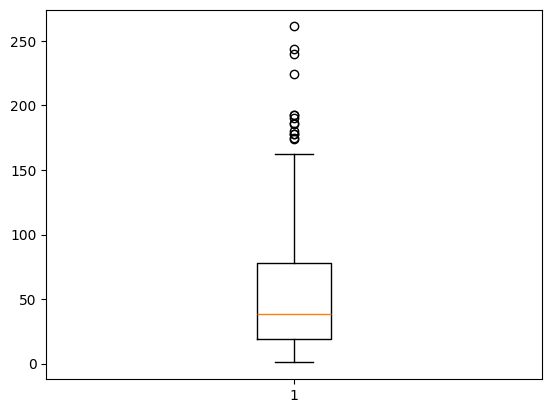

In [47]:
acceleration = np.array(stat['time_l']) / np.array(stat['time_h'])
plt.boxplot(acceleration)

In [48]:
idx = np.argmin(stat['delta'])

In [49]:
p1,p2 = stat['l'][idx], stat['h_l'][idx]

In [50]:
p1,p2

(8338.896000000002, 8338.895999999999)

In [51]:
p = stat['p'][idx]
hp = stat['h_p'][idx]
len(p), len(hp)

(54, 54)

In [52]:
np.array(p), np.array(hp)

(array([ 861499301, 5272857655, 5272857684,  861499277, 5272857752,
        5272857773, 5303705148,  861499233, 5303705142, 3881491026,
         847059866, 1211686759, 3100552383,  251528356, 3094455211,
        1211686665, 3094455657, 1211686791, 3094455707, 3094455722,
        3094455743, 1211686753, 3094455776,  251528359, 1271789168,
        2027953582,  620100726, 2027953606, 5316681276, 1576824945,
        1289849118, 1289849094, 1289849092,  620100727, 1289849113,
        1289849102, 1289849106, 1289849100, 1289849105,  620100728,
        2027953685, 1526038958, 1526038959, 1526038968, 1526038979,
        1526038980, 2028569909, 1521196280, 1521196298, 1521196316,
        2028570322, 2028474183, 2028474185, 2028570416]),
 array([ 861499301, 5272857655, 5272857684,  861499277, 5272857752,
        5272857773, 5303705148,  861499233, 5303705142, 3881491026,
         847059866, 1211686759, 3100552383,  251528356, 3094455211,
        1211686665, 3094455657, 1211686791, 3094455707, 30

In [ ]:
u,v

In [ ]:
bi_dijkstra_pfa(g, u,v)